<a href="https://colab.research.google.com/github/meysam-kazemi/drive-unet/blob/main/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/RETINAL/

/content/drive/.shortcut-targets-by-id/19v_-z68QIom5bSkKsoiETI2xN8cPjPox/RETINAL


In [ ]:
%ls

augment.ipynb  files/         models/    outputs/  saved/  test.zip   training.zip  unet.ipynb
datasets/      fr-unet.ipynb  new_data/  runs/     test/   training/  unet-2.ipynb


In [ ]:
# Libraries

import os
import time
import random
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from glob import glob
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
import cv2
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Utils

def add_metric_history(metrics, hist):
    for k, _ in hist.items():
      hist[k].append(metrics[k])
    return hist


""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

""" Create a directory. """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Calculate the time taken """
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# Data

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], 0)  # gray scale
        image = image/255.0 ## (512, 512)
        # image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = np.expand_dims(image, axis=0)  # (1, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0   ## (512, 512)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        mask = (mask > 0.5)*1 # binarize
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

# Loss

In [ ]:
# Loss

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

## Metrics

In [ ]:
import numpy as np
import torch
import cv2
from sklearn.metrics import roc_auc_score

def get_metrics(predict, target, threshold=None, predict_b=None):
    predict = torch.sigmoid(predict).cpu().detach().numpy().flatten()
    if predict_b is not None:
        predict_b = predict_b.flatten()
    else:
        predict_b = np.where(predict >= threshold, 1, 0)
    if torch.is_tensor(target):
        target = target.cpu().detach().numpy().flatten()
    else:
        target = target.flatten()
    tp = (predict_b * target).sum()
    tn = ((1 - predict_b) * (1 - target)).sum()
    fp = ((1 - target) * predict_b).sum()
    fn = ((1 - predict_b) * target).sum()
    auc = roc_auc_score(target>0.5, predict)
    acc = (tp + tn) / (tp + fp + fn + tn)
    pre = tp / (tp + fp)
    sen = tp / (tp + fn)
    spe = tn / (tn + fp)
    iou = tp / (tp + fp + fn)
    f1 = 2 * pre * sen / (pre + sen)
    return {
        "AUC": np.round(auc, 4),
        "F1": np.round(f1, 4),
        "Acc": np.round(acc, 4),
        "Sen": np.round(sen, 4),
        "Spe": np.round(spe, 4),
        "Pre": np.round(pre, 4),
        "IOU": np.round(iou, 4),
    }


def count_connect_component(predict, target, threshold=None, connectivity=8):
    if threshold != None:
        predict = torch.sigmoid(predict).cpu().detach().numpy()
        predict = np.where(predict >= threshold, 1, 0)
    if torch.is_tensor(target):
        target = target.cpu().detach().numpy()
    pre_n, _, _, _ = cv2.connectedComponentsWithStats(np.asarray(
        predict, dtype=np.uint8)*255, connectivity=connectivity)
    gt_n, _, _, _ = cv2.connectedComponentsWithStats(np.asarray(
        target, dtype=np.uint8)*255, connectivity=connectivity)
    return pre_n/gt_n

# Unet

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [ ]:
# Model

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(1, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs

# x = torch.randn((2, 1, 512, 512))
model = build_unet()
# y = model(x)
# print(y.shape)

In [ ]:
from torchsummary import summary
summary(model,(1,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]             640
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,928
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
        conv_block-7         [-1, 64, 512, 512]               0
         MaxPool2d-8         [-1, 64, 256, 256]               0
     encoder_block-9  [[-1, 64, 512, 512], [-1, 64, 256, 256]]               0
           Conv2d-10        [-1, 128, 256, 256]          73,856
      BatchNorm2d-11        [-1, 128, 256, 256]             256
             ReLU-12        [-1, 128, 256, 256]               0
           Conv2d-13        [-1, 128, 256, 256]         147,584
      BatchNorm2d-14    

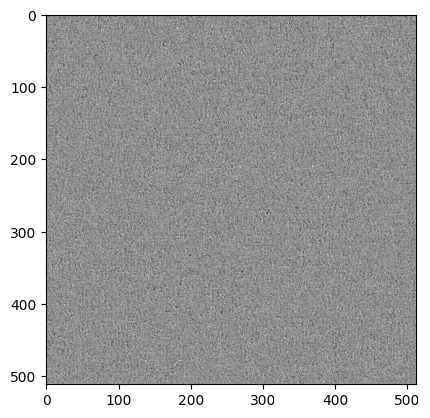

In [ ]:
plt.imshow(y[0,0].detach().numpy(), 'gray')

In [ ]:
# """load pre-trained model"""
# checkpoint = torch.load("models/unet-last-epoch.pth")
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# scheduler.load_state_dict(checkpoint['scheduler'])
# init_epoch = checkpoint['epoch']

# Train

In [ ]:
""" Seeding """
seeding(42)

""" Directories """
create_dir("files")

""" Load dataset """
train_x = sorted(glob("./new_data/train/image/*"))
train_y = sorted(glob("./new_data/train/mask/*"))

# valid_x = sorted(glob("./new_data/test/image/*"))
# valid_y = sorted(glob("./new_data/test/mask/*"))

""" Hyperparameters """
H = 512
W = 512
size = (H, W)
batch_size = 16
num_epochs = 80
lr = 1e-4
checkpoint_path = "models/unet.pth"

""" Dataset and loader """
dataset = DriveDataset(train_x, train_y)
validation_split = 0.2
train_size = int((1 - validation_split) * len(dataset))
valid_size = len(dataset) - train_size
# split dataset to train and valid
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)


print(f"Dataset Size:\nTrain: {len(train_loader)} - Valid: {len(valid_loader)}\n")




Dataset Size:
Train: 20 - Valid: 5



In [ ]:
model = model.to(0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
# loss_fn = DiceBCELoss()
loss_fn = DiceLoss()
scaler = torch.cuda.amp.GradScaler()


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
create_dir("outputs/unet-training/")

In [ ]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()

In [ ]:
# """load pre-trained model"""
# checkpoint = torch.load("models/.pth")
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# scheduler.load_state_dict(checkpoint['scheduler'])
# init_epoch = checkpoint['epoch']

In [ ]:
# sigm = nn.functional.sigmoid
def train(model, loader, optimizer, loss_fn, scale,  amp=True):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to("cuda")
        y = y.to("cuda")

        optimizer.zero_grad()

        if amp:
            with torch.cuda.amp.autocast():  # Enable mixed precision
                outputs = model(x)
                loss = loss_fn(outputs, y)

            scaler.scale(loss).backward()  # Scale the loss and backpropagate
            scaler.step(optimizer)  # Step the optimizer
            scaler.update()  # Update the scaler
        else:
            outputs = model(x)
            loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()


        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return x,y, outputs, epoch_loss

def evaluate(model, loader, loss_fn, amp=False):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to("cuda", torch.float16)
            y = y.to("cuda", torch.float16)
            if amp:
                with torch.cuda.amp.autocast():  # Enable mixed precision
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

            else:
                outputs = model(x)
                loss = loss_fn(outputs, y)



            epoch_loss += loss.item()

        epoch_loss = epoch_loss/(len(loader))
    return x,y, outputs, epoch_loss


In [ ]:
torch.cuda.empty_cache()

In [ ]:
num_epochs = 200

In [ ]:
""" Training the model """
best_valid_loss = float("inf")
history = {'epoch': [], 'train_loss': [], 'valid_loss': [], "time": []}
train_metric_hist = {'AUC':[],'F1':[],'Acc':[],'Sen':[],'Spe':[],'Pre':[],'IOU':[]}
valid_metric_hist = {'AUC':[],'F1':[],'Acc':[],'Sen':[],'Spe':[],'Pre':[],'IOU':[]}

for epoch in range(1, num_epochs+1):
    start_time = time.time()

    x_tr, y_tr, outputs_tr, train_loss = train(model, train_loader, optimizer, loss_fn, scaler, True)
    x_val, y_val, outputs_val, valid_loss = evaluate(model, valid_loader, loss_fn, amp=True)
    # History
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['epoch'].append(epoch)
    ep_time = round(time.time()-start_time, 2)
    history['time'].append(ep_time)

    # metrics
    metric_train = get_metrics(predict=outputs_tr, target=y_tr,threshold=0.5)
    metric_valid = get_metrics(predict=outputs_val, target=y_val, threshold=0.5)

    train_metric_hist = add_metric_history(metric_train, train_metric_hist)
    valid_metric_hist = add_metric_history(metric_valid, valid_metric_hist)

    print(f'Epoch [{epoch}/{num_epochs}] | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | Time : {ep_time} s')

    # Save the model and images every 10 epochs
    if (epoch) % 10 == 0:
        state = {
        'history': history,
        'train_metric_history': train_metric_hist,
        'valid_metric_history': valid_metric_hist,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict()
        }
        torch.save(state, f"models/model_epoch_{epoch}.pth")

        # Save 9 image results
        folder_path = f'outputs/unet-training/results/epoch{epoch}/'
        create_dir(folder_path)
        save_image(x_val.cpu(), folder_path+'images.png', nrow=2, normalize=True)
        save_image(y_val.cpu(), folder_path+'original_masks.png', nrow=2, normalize=True)
        save_image(outputs_val.cpu(), folder_path+'outputs.png', nrow=2, normalize=True)



    """ Saving the model """
    if valid_loss < best_valid_loss:
        data_str = "\033[33mValid loss improved\033[00m"
        print(data_str)

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "models/best-unet.pth")


Epoch [1/200] | Train Loss: 0.6080 | Valid Loss: 0.6294 | Time : 39.31 s
Valid loss improved
Epoch [2/200] | Train Loss: 0.5864 | Valid Loss: 0.5822 | Time : 40.0 s
Valid loss improved
Epoch [3/200] | Train Loss: 0.5701 | Valid Loss: 0.5709 | Time : 38.93 s
Valid loss improved
Epoch [4/200] | Train Loss: 0.5563 | Valid Loss: 0.5626 | Time : 39.44 s
Valid loss improved
Epoch [5/200] | Train Loss: 0.5445 | Valid Loss: 0.5444 | Time : 39.1 s
Valid loss improved
Epoch [6/200] | Train Loss: 0.5322 | Valid Loss: 0.5322 | Time : 39.42 s
Valid loss improved
Epoch [7/200] | Train Loss: 0.5204 | Valid Loss: 0.5231 | Time : 39.44 s
Valid loss improved
Epoch [8/200] | Train Loss: 0.5094 | Valid Loss: 0.5163 | Time : 39.26 s
Valid loss improved
Epoch [9/200] | Train Loss: 0.4977 | Valid Loss: 0.4980 | Time : 39.43 s
Valid loss improved
Epoch [10/200] | Train Loss: 0.4853 | Valid Loss: 0.4934 | Time : 39.69 s
Valid loss improved
Epoch [11/200] | Train Loss: 0.4734 | Valid Loss: 0.4826 | Time : 39.54

## test

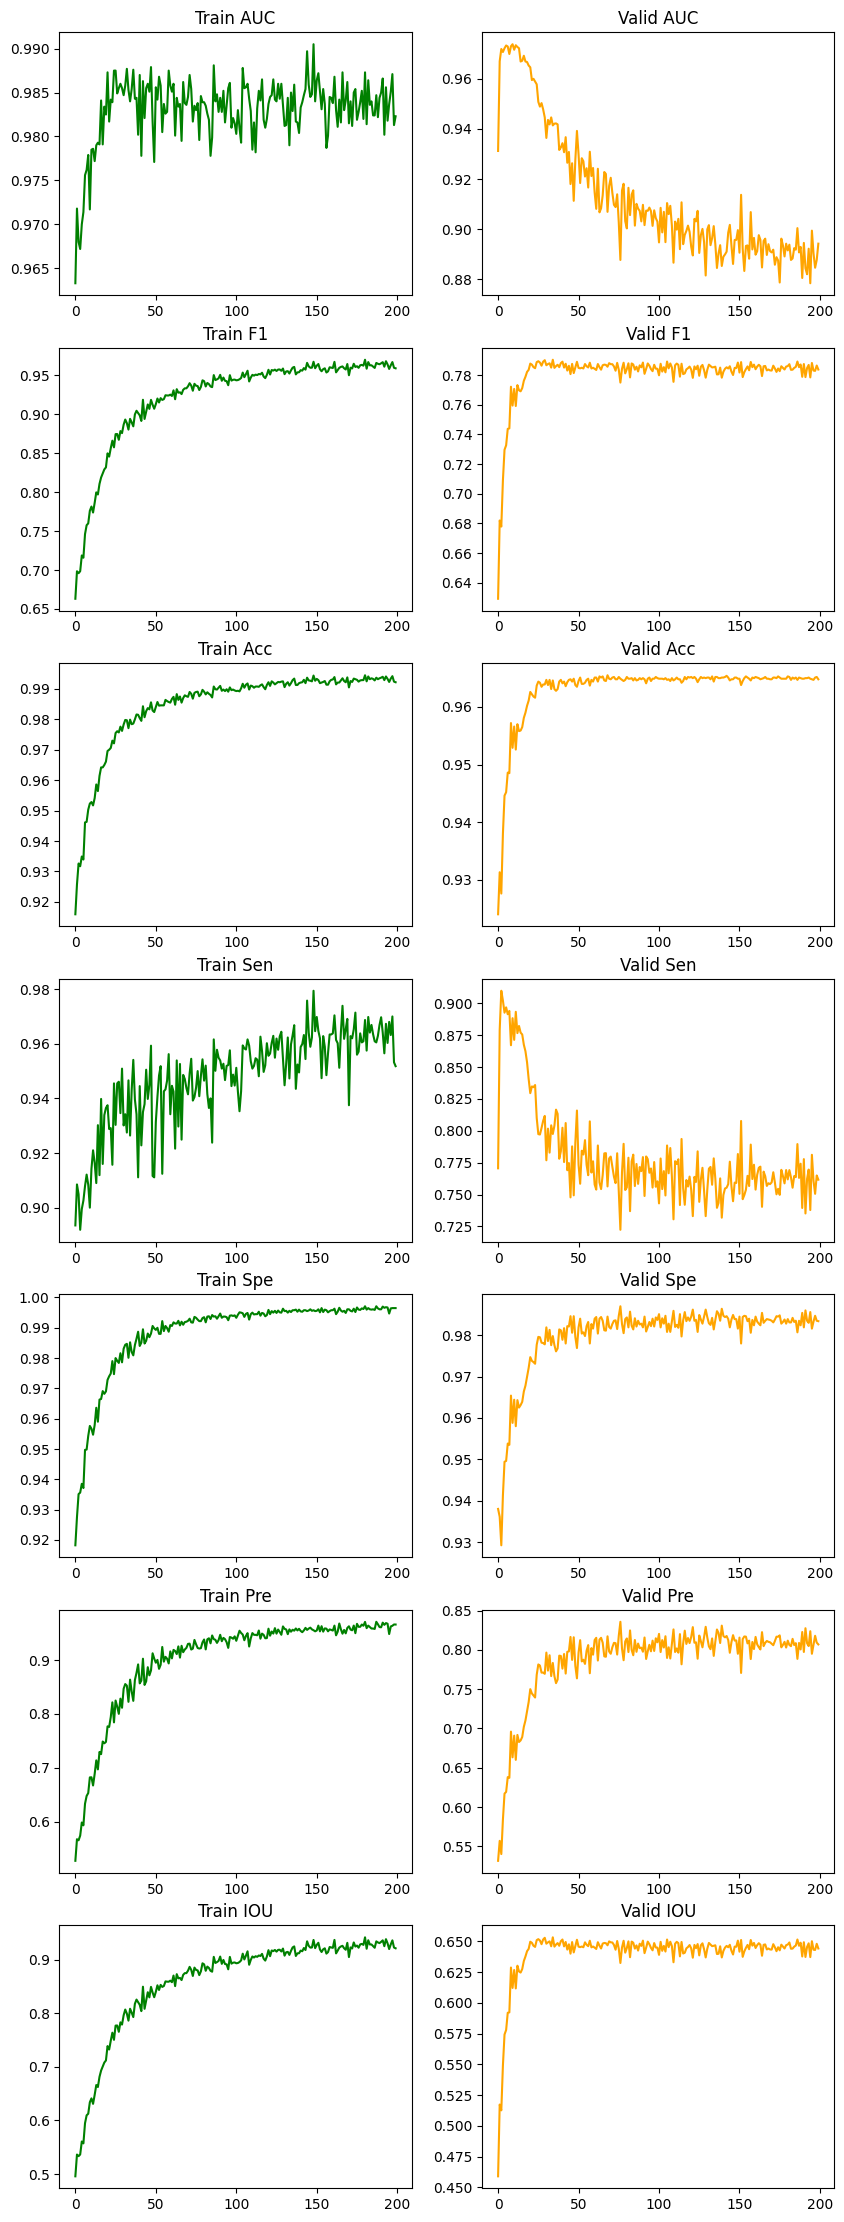

In [ ]:
fig, axs = plt.subplots(7,2, figsize=(10,28))
for i, (k,v) in enumerate(train_metric_hist.items()):
  axs[i,0].plot(v, c='green');axs[i,0].set_title(f'Train {k}')
for i, (k,v) in enumerate(valid_metric_hist.items()):
  axs[i,1].plot(v, c='orange');axs[i,1].set_title(f'Valid {k}')

In [ ]:
create_dir("figs")
fig.savefig('figs/unet-80epoch.png')

In [ ]:
# Load pre-trained Model
checkpoint = torch.load("models/unet-last-epoch80.pth")
model.load_state_dict(checkpoint['state_dict'])

In [ ]:
def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in (loader):
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/(len(loader))
    return epoch_loss


In [ ]:
""" Seeding """
seeding(42)

""" Directories """
create_dir("files")

""" Load dataset """
train_x = sorted(glob("./new_data/train/image/*"))
train_y = sorted(glob("./new_data/train/mask/*"))

valid_x = sorted(glob("./new_data/test/image/*"))
valid_y = sorted(glob("./new_data/test/mask/*"))

data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
print(data_str)

""" Hyperparameters """
H = 512
W = 512
size = (H, W)
batch_size = 4
num_epochs = 150
lr = 1e-4


In [ ]:
""" Dataset and loader """
train_dataset = DriveDataset(train_x, train_y)
valid_dataset = DriveDataset(valid_x, valid_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

device = torch.device('cuda')
model = build_unet()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()


In [ ]:
eval_loss = evaluate(model, train_loader, loss_fn, device)
print(f"evaluation loss for new train data : {eval_loss}")

In [ ]:
create_dir("./outputs/")
create_dir("./outputs/unet")
create_dir("./outputs/unet/image")
create_dir("./outputs/unet/result")

In [ ]:
i = 0

model.eval()
with torch.no_grad():
    for x, _ in train_loader:
      if i== 20:
        break
      for j in range(4):
        cv2.imwrite(f"outputs/unet/image/{i}-{j}.png", np.array(x[j]).transpose([1,2,0]))
      x = x.to(device, dtype=torch.float32)
      y_pred = model(x)
      for j in range(4):
        a = y_pred[j].to('cpu').squeeze()
        a = (a-a.min())/(a.max()-a.min())
        a = (a > 0.5)
        a = np.array(a*255, dtype="uint8")
        cv2.imwrite(f"outputs/unet/result/{i}-{j}.png", a)

      i += 1

In [ ]:
plt.imshow(a,'gray',
           vmax=255,vmin=0)

In [ ]:
def mask_parse(mask):
  mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
  mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
  return mask

def renorm(mask):
  mn = mask.min()
  mx = mask.max()
  mask = 255*(mask-mn)/(mx-mn)
  return mask

time_taken = []
model.eval()
for i, x  in enumerate(train_x):
  if i==20:
    break

  """ Extract the name """
  name = x.split("/")[-1].split(".")[0]

  """ Reading image """
  image = cv2.imread(x, cv2.IMREAD_COLOR) ## (512, 512, 3)
  cv2.imwrite(f"./outputs/unet/image/{i}.png", image)
  ## image = cv2.resize(image, size)
  x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
  x = x/255.0
  x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
  x = x.astype(np.float32)
  x = torch.from_numpy(x)
  x = x.to(device)

  with torch.no_grad():
      """ Prediction and Calculating FPS """
      start_time = time.time()
      pred_y = model(x)
      # pred_y = torch.sigmoid(pred_y)
      total_time = time.time() - start_time
      time_taken.append(total_time)

      pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
      pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
      print("1:", pred_y.min(), pred_y.max())
      pred_y = renorm(pred_y)
      pred_y = pred_y > 0.5
      pred_y = np.array(pred_y*255, dtype=np.uint8)
      print('2: ', pred_y.min(), pred_y.max())

  """ Saving masks """
  pred_y = mask_parse(pred_y)

  cv2.imwrite(f"outputs/unet/result/{i}.png", pred_y)

print("mean time: ", np.mean(time_taken))

## Train

In [ ]:
# Train

def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/(len(loader)+1e-5)
    return epoch_loss


""" Seeding """
seeding(42)

""" Directories """
create_dir("files")

""" Load dataset """
train_x = sorted(glob("./new_data/train/image/*"))
train_y = sorted(glob("./new_data/train/mask/*"))

valid_x = sorted(glob("./new_data/test/image/*"))
valid_y = sorted(glob("./new_data/test/mask/*"))

data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
print(data_str)

""" Hyperparameters """
H = 512
W = 512
size = (H, W)
batch_size = 4
num_epochs = 150
lr = 1e-4
checkpoint_path = "models/unet.pth"

""" Dataset and loader """
train_dataset = DriveDataset(train_x, train_y)
valid_dataset = DriveDataset(valid_x, valid_y)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

device = torch.device('cuda')
model = build_unet()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()

"""load pre-trained model"""
checkpoint = torch.load("models/unet-last-epoch.pth")
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])
init_epoch = checkpoint['epoch']

In [ ]:
""" Training the model """
best_valid_loss = float("inf")

for epoch in range(init_epoch+1, num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    # valid_loss = evaluate(model, valid_loader, loss_fn, device)

    """ Saving the model """
    if train_loss < best_valid_loss:
        data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {train_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
        print(data_str)

        best_valid_loss = train_loss
        torch.save(model.state_dict(), checkpoint_path)

    state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict()
    }

    torch.save(state, "models/unet-second-train-last-epoch.pth")
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
    data_str += f'\tTrain Loss: {train_loss:.3f}\n'
    # data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
    print(data_str)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Test

import os, time
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
import imageio
import torch
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

from model import build_unet
from utils import create_dir, seeding

def calculate_metrics(y_true, y_pred):
    """ Ground truth """
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]

def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Folders """
    create_dir("results")

    """ Load dataset """
    test_x = sorted(glob("../new_data/test/image/*"))
    test_y = sorted(glob("../new_data/test/mask/*"))

    """ Hyperparameters """
    H = 512
    W = 512
    size = (W, H)
    checkpoint_path = "files/checkpoint.pth"

    """ Load the checkpoint """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = build_unet()
    model = model.to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
    time_taken = []

    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## (512, 512, 3)
        ## image = cv2.resize(image, size)
        x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
        x = x/255.0
        x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        x = x.to(device)

        """ Reading mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
        ## mask = cv2.resize(mask, size)
        y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
        y = y/255.0
        y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
        y = y.astype(np.float32)
        y = torch.from_numpy(y)
        y = y.to(device)

        with torch.no_grad():
            """ Prediction and Calculating FPS """
            start_time = time.time()
            pred_y = model(x)
            pred_y = torch.sigmoid(pred_y)
            total_time = time.time() - start_time
            time_taken.append(total_time)


            score = calculate_metrics(y, pred_y)
            metrics_score = list(map(add, metrics_score, score))
            pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
            pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
            pred_y = pred_y > 0.5
            pred_y = np.array(pred_y, dtype=np.uint8)

        """ Saving masks """
        ori_mask = mask_parse(mask)
        pred_y = mask_parse(pred_y)
        line = np.ones((size[1], 10, 3)) * 128

        cat_images = np.concatenate(
            [image, line, ori_mask, line, pred_y * 255], axis=1
        )
        cv2.imwrite(f"results/{name}.png", cat_images)

    jaccard = metrics_score[0]/len(test_x)
    f1 = metrics_score[1]/len(test_x)
    recall = metrics_score[2]/len(test_x)
    precision = metrics_score[3]/len(test_x)
    acc = metrics_score[4]/len(test_x)
    print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")

    fps = 1/np.mean(time_taken)
    print("FPS: ", fps)